In [1]:
#Import the required libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import optuna

C:\Users\suman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load the dataset and preprocess the CIFAR-10 dataset 
(X_train, y_train), (X_test, y_test)=cifar10.load_data()

#Normalize the dataset
X_train=X_train.astype('float32')/255.0
X_test=X_test.astype('float32')/255.0

#One hot encoding of labels
y_train= to_categorical(y_train,10)
y_test=to_categorical(y_test,10)



In [3]:
#Split the dataset into Training, validation

X_val =X_train[-10000:]
y_val=y_train[-10000:]
X_train=X_train[:-10000]
y_train=y_train[:-10000]


In [4]:
#Implement CNN model

def build_model(regularizer=None):
    model=Sequential([
        Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regularizer),
        Dense(10, activation='softmax',kernel_regularizer=regularizer)

    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model

C:\Users\suman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 - 12s - 10ms/step - accuracy: 0.4731 - loss: 1.4665 - val_accuracy: 0.5858 - val_loss: 1.2006
Epoch 2/10
1250/1250 - 10s - 8ms/step - accuracy: 0.6145 - loss: 1.1033 - val_accuracy: 0.6137 - val_loss: 1.1064
Epoch 3/10
1250/1250 - 10s - 8ms/step - accuracy: 0.6683 - loss: 0.9537 - val_accuracy: 0.6708 - val_loss: 0.9587
Epoch 4/10
1250/1250 - 10s - 8ms/step - accuracy: 0.7026 - loss: 0.8542 - val_accuracy: 0.6836 - val_loss: 0.9272
Epoch 5/10
1250/1250 - 10s - 8ms/step - accuracy: 0.7339 - loss: 0.7617 - val_accuracy: 0.6825 - val_loss: 0.9407
Epoch 6/10
1250/1250 - 10s - 8ms/step - accuracy: 0.7620 - loss: 0.6862 - val_accuracy: 0.6885 - val_loss: 0.9140
Epoch 7/10
1250/1250 - 10s - 8ms/step - accuracy: 0.7850 - loss: 0.6177 - val_accuracy: 0.6944 - val_loss: 0.9489
Epoch 8/10
1250/1250 - 10s - 8ms/step - accuracy: 0.8100 - loss: 0.5472 - val_accuracy: 0.6783 - val_loss: 1.0374
Epoch 9/10
1250/1250 - 10s - 8ms/step - accuracy: 0.8292 - loss: 0.4835 - val_accuracy:

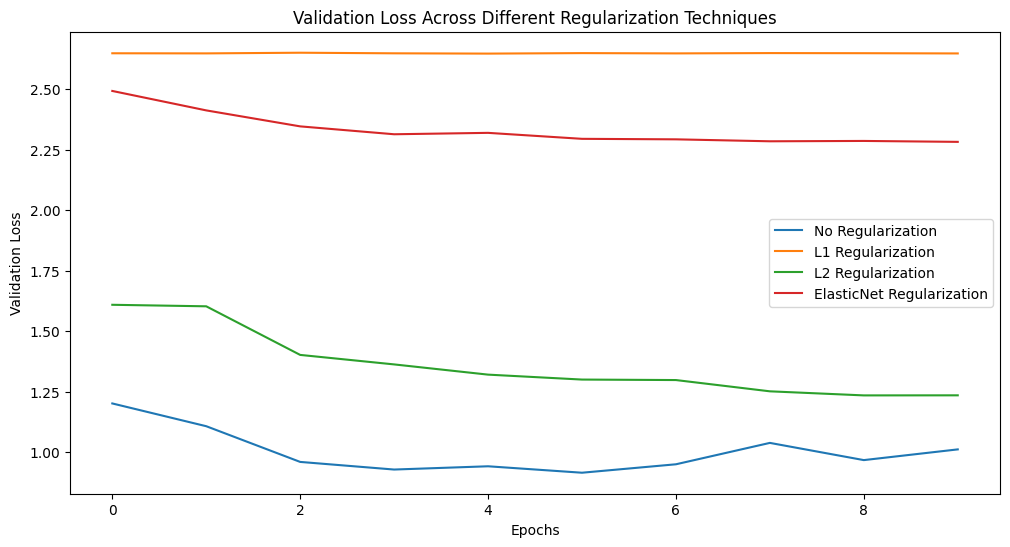

In [5]:
#Model without Regularization
model_no_reg=build_model()
history_no_reg=model_no_reg.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10, verbose=2)

#Model with L1 Regularization
model_l1=build_model(regularizer=l1(0.01))
history_l1=model_l1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10, verbose=2)

#Model with L2 Regularization
model_l2=build_model(regularizer=l2(0.01))
history_l2=model_l2.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10, verbose=2)

#Model with ElasticNet (L1+L2) regularization
model_elasticnet = build_model(regularizer=l1_l2(l1=0.01, l2=0.01))
history_elasticnet=model_elasticnet.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10, verbose=2)

#Plotting the validation loss for all models

plt.figure(figsize=(12,6))
plt.plot(history_no_reg.history['val_loss'], label='No Regularization')
plt.plot(history_l1.history['val_loss'],label='L1 Regularization')
plt.plot(history_l2.history['val_loss'], label='L2 Regularization')
plt.plot(history_elasticnet.history['val_loss'],label='ElasticNet Regularization')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Across Different Regularization Techniques')
plt.show()

In [6]:
#Optuna Optimization for ElasticNet Regularization

def objective(trial):
    l1_value=trial.suggest_loguniform('l1',1e-5,1e-2)
    l2_value=trial.suggest_loguniform('l2',1e-5,1e-2)

    model_optuna = Sequential([
        Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_value,l2=l2_value)),
        Dense(10, activation='softmax',kernel_regularizer=l1_l2(l1=l1_value,l2=l2_value))
    ])
    model_optuna.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    history=model_optuna.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=10, verbose=0)

    val_loss=min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Best trial: Score {}, params {}'.format(study.best_trial.value,study.best_trial.params))

#Now we will use the best values of l1 and l2
best_l1 =study.best_trial.params['l1']
best_l2=study.best_trial.params['l2']

model_final=build_model(regularizer=l1_l2(l1=best_l1,l2=best_l2))
history_final=model_final.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10, verbose=2)

#The Final Metrics 
test_loss, test_acc=model_final.evaluate(X_test,y_test)
print(f"Test Accuracy:{test_acc:.4f}, Test Loss:{test_loss:.4f}")


[I 2024-08-26 12:29:52,507] A new study created in memory with name: no-name-b692144c-69a0-4c1b-bb54-477dc662921e
C:\Users\suman\AppData\Local\Temp\ipykernel_6840\220791171.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_value=trial.suggest_loguniform('l1',1e-5,1e-2)
C:\Users\suman\AppData\Local\Temp\ipykernel_6840\220791171.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_value=trial.suggest_loguniform('l2',1e-5,1e-2)
[I 2024-08-26 12:31:46,315] Trial 0 finished with value: 1.3732658624649048 and parameters: {'l1': 0.0010109544845814961, 'l2': 0.001919120874635294}. Best is trial 0 with value: 1.3732658624649048.
[I 2024-08-26 12:33:39,338] Trial 1 finishe

Best trial: Score 1.1115978956222534, params {'l1': 0.0001111801839720283, 'l2': 0.00030348028700696205}
Epoch 1/10
1250/1250 - 13s - 10ms/step - accuracy: 0.4477 - loss: 1.7161 - val_accuracy: 0.5240 - val_loss: 1.5198
Epoch 2/10
1250/1250 - 11s - 9ms/step - accuracy: 0.5756 - loss: 1.3841 - val_accuracy: 0.6060 - val_loss: 1.3087
Epoch 3/10
1250/1250 - 11s - 9ms/step - accuracy: 0.6179 - loss: 1.2739 - val_accuracy: 0.6382 - val_loss: 1.2365
Epoch 4/10
1250/1250 - 11s - 9ms/step - accuracy: 0.6487 - loss: 1.2092 - val_accuracy: 0.6486 - val_loss: 1.2165
Epoch 5/10
1250/1250 - 11s - 9ms/step - accuracy: 0.6665 - loss: 1.1598 - val_accuracy: 0.6402 - val_loss: 1.2447
Epoch 6/10
1250/1250 - 11s - 9ms/step - accuracy: 0.6816 - loss: 1.1229 - val_accuracy: 0.6624 - val_loss: 1.1799
Epoch 7/10
1250/1250 - 11s - 9ms/step - accuracy: 0.6938 - loss: 1.0905 - val_accuracy: 0.6619 - val_loss: 1.1788
Epoch 8/10
1250/1250 - 12s - 10ms/step - accuracy: 0.7085 - loss: 1.0599 - val_accuracy: 0.6749 